# TODO

 - Embedding for all the lines of the document
 <!-- - Embeddings for all concepts -->
 <!-- - Each concept has a list of neighboring concepts based on similarity (e.g. cosine similarity) -->
 <!-- - The searched term will be embedded and compared to all concepts -->
 - The searched term will be embedded and compared to all lines of the corpus (with hashing to accelerate)
 <!-- - Return patients having the neighboring concepts of the searched term -->
 - Return patients that have big similarity

In [ ]:
# %pip install -U sentence-transformers -q

### Importing

In [1]:
# ----------------------------------- tech ----------------------------------- #
import os
import glob
import pickle

# ---------------------------- Display and friends --------------------------- #
from tqdm import tqdm
from matplotlib import pyplot as plt

# ------------------------- Transformers and freinds ------------------------- #
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from sentence_transformers import SentenceTransformer, util
import torch
import torch.nn.functional as F
import numpy as np

# ------------------------ Classification and friends ------------------------ #
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE

# ----------------------------------- local ---------------------------------- #
from data_preprocessing import Get_and_process_data
from utils.parse_data import parse_concept

### Configurations

In [2]:
lines_per_tokenization = 5
filename_split_key = "__at__"
# Load model from HuggingFace Hub
device = "cuda"
model_checkpoint = "sentence-transformers/multi-qa-MiniLM-L6-cos-v1"
# model_checkpoint = "gsarti/scibert-nli"
# model_checkpoint = "logs/scibert_20_epochs_64_batch_99_train_split"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModel.from_pretrained(model_checkpoint)
data_path = "../data/train/txt"
embeddings_path = data_path + os.sep + "embeddings"
similarity = torch.nn.CosineSimilarity()
if not os.path.exists(embeddings_path):
    os.makedirs(embeddings_path)

### utils

In [3]:
#Mean Pooling - Take average of all tokens
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


#Encode text
def encode(texts, tokenizer = tokenizer, model= model):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    return embeddings

def find_cluster(query_emb, clustered_data, similarity=similarity):
    best_cluster = None
    best_score = -1
    for i in clustered_data.keys():
        center = clustered_data[i]["center"]
        score = similarity(query_emb, center)
        if score >= best_score:
            best_cluster = i
            best_score = score
    return best_cluster

def text_splitter(text, file_path):
    con_file_path = os.path.dirname(os.path.dirname(file_path)) + os.sep + "concept" + os.sep + os.path.basename(file_path).split(".")[0] + ".con"
    concepts_lines = list(set(parse_concept(con_file_path)["start_line"]))
    concepts_lines.sort()
    texts = text.split("\n")
    concepts = []
    for line in concepts_lines:
        concepts.append(texts[line-1])
    return concepts

def semantic_search_base(query_emb, doc_emb, docs):
    #Compute dot score between query and all document embeddings
    scores = torch.mm(query_emb, doc_emb.transpose(0, 1))[0].cpu().tolist()

    #Combine docs & scores
    doc_score_pairs = list(zip(docs, scores))

    #Sort by decreasing score
    doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)
    print(doc_score_pairs)
    #Output passages & scores
    for doc, score in doc_score_pairs:
        print("==> ",score) 
        print(doc)
        
def forward(texts, tokenizer= tokenizer, model= model):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    return embeddings


def forward_doc(text, file_path, tokenizer= tokenizer, model= model, no_grad= False):
    texts = text_splitter(text, file_path) 
    if len(texts) == 0:
        return []
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    
    # Compute token embeddings
    if no_grad:
        with torch.no_grad():
            model_output = model(**encoded_input, return_dict=True)
    else :
        model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # NOTE: This is an easy approach
    # another mean pooling over the lines of the document
    # embeddings = torch.mean(embeddings_lines, 0).unsqueeze(0)
    
    # Normalize embeddings
    embeddings = F.normalize(embeddings,  p=2, dim=1)
    
    return embeddings


### Testing Inference from checkpoint

In [4]:
model =model.eval()

In [5]:
# Sentences we want sentence embeddings for
query = "How many people live in London?"
docs = ["Around 9 Million people live in London", "London is known for its financial district"]

#Encode query and docs
query_emb = encode(query)
doc_emb = encode(docs)

semantic_search_base(query_emb, doc_emb, docs)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[('Around 9 Million people live in London', 0.9155025482177734), ('London is known for its financial district', 0.8950100541114807)]
==>  0.9155025482177734
Around 9 Million people live in London
==>  0.8950100541114807
London is known for its financial district


0.915637195110321 Around 9 Million people live in London


0.49475765228271484 London is known for its financial district

### Testing training

In [7]:
encoded_input = tokenizer(query, padding=True, truncation=True, return_tensors='pt')
model_output = model(**encoded_input, return_dict=True)
# model_output

In [8]:
encoded_input["input_ids"].shape

torch.Size([1, 9])

In [9]:
model_output.last_hidden_state.shape

torch.Size([1, 9, 768])

In [10]:
model_output.pooler_output.shape

torch.Size([1, 768])

In [11]:
# model.train()

query = "How many people live in London?"
answer = "Around 9 Million people live in London"

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

q = forward(query)
print("q shape :", q.shape)
a = forward(answer)
print("a shape :", a.shape)

loss = loss_fn(a,q)

optimizer.zero_grad()
# loss.backward()
# optimizer.step()

q shape : torch.Size([1, 768])
a shape : torch.Size([1, 768])


### Getting data

In [39]:
doc = ""
file_path = "../data/train/txt/018636330_DH.txt"
with open(file_path) as f:
    doc = f.read()
    
doc_emb = forward_doc(doc, file_path, no_grad= True)
doc_emb.shape

torch.Size([22, 384])

In [47]:
c_emb= encode("hyperreflexia in feet")
semantic_search_base(c_emb, doc_emb, text_splitter(doc, file_path))

[('Within the past year , these symptoms have progressively gotten worse , to encompass also her feet .', 0.4309232831001282), ('She had hyperreflexia in both the bilateral upper and lower extremities .', 0.37314465641975403), ('Immediately postop , her exam only improved slightly in her hyperreflexia .', 0.356035053730011), ('She had a workup by her neurologist and an MRI revealed a C5-6 disc herniation with cord compression and a T2 signal change at that level .', 0.2994070053100586), ('C5-6 disc herniation with cord compression and myelopathy .', 0.29181385040283203), ('Significant for hypertension , hyperlipidemia .', 0.2753830552101135), ('Microscopic anterior cervical diskectomy at C5-6 and fusion .', 0.21673107147216797), ('The patient is a 63-year-old female with a three-year history of bilateral hand numbness and occasional weakness .', 0.21050399541854858), ('She had a Hoffman &apos;s sign greater on the right than the left and she had 10 beats of clonus in the right foot and

### Saving embeddings

In [28]:
# what are the elements in the folder ../data/train/txt/
all_docs = {}
text_files = glob.glob(data_path + os.sep +  "*.txt")
for file_path in tqdm(text_files, "Encoding documents", ascii=True):
    with open(file_path) as f:
        doc = f.read()
    file_name = os.path.basename(file_path).split(".")[0]
    embeddings = forward_doc(doc, file_path, no_grad=True)
    for i,emb in enumerate(embeddings):
        all_docs[file_name+filename_split_key+str(i)] = emb.unsqueeze(0)

Encoding documents: 100%|##########| 170/170 [01:50<00:00,  1.54it/s]


In [29]:
with open(embeddings_path + os.sep + "all_docs_concepts.pkl", "wb") as f:
    pickle.dump(all_docs, f)

In [6]:
# with open(embeddings_path + os.sep + "all_docs_concepts.pkl", "rb") as f:
#     all_docs = pickle.load(f)

In [7]:
len(all_docs)

7960

### Classify the embeddings

We can use hierachical clustering to classify the embeddings for a very search efficient task. But for simplicity, we will only perform K-means clustering.

In [31]:
sample_names_list = list(map(lambda x: x[0], all_docs.items()))[:]
sample_values_list = list(map(lambda x: x[1], all_docs.items()))[:]
sample = np.array(list(map(lambda x: x.numpy().reshape(-1), sample_values_list))) # array of 1 dim vectors
sample.shape

(7960, 384)

#### Test hierachical clustering

In [18]:
clustering = AgglomerativeClustering(distance_threshold=0.7, n_clusters=None).fit(sample)

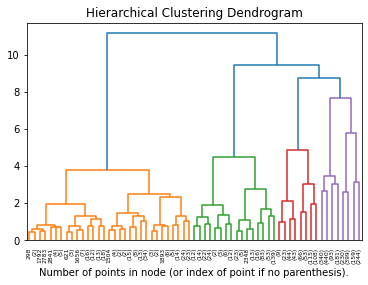

In [19]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

#### Test K-means clustering

In [32]:
clustering = KMeans(n_clusters = 10).fit(sample)

/home/mus5900/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mus5900/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


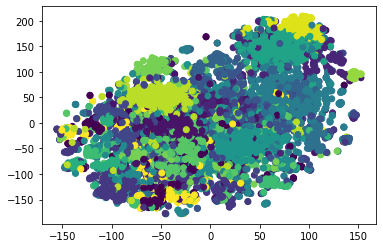

<Figure size 1440x720 with 0 Axes>

In [37]:
# Scatter plot using TSNE
def plot_clutering(sample):
    new_sample = TSNE(n_components=2).fit_transform(sample)
    plt.scatter(new_sample[:, 0], new_sample[:, 1], c=clustering.labels_)
    plt.figure(figsize=(20, 10))
    plt.show()
    # # plot in 3D
    # new_sample_3D = TSNE(n_components=3).fit_transform(sample)
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(new_sample_3D[:, 0], new_sample_3D[:, 1], new_sample_3D[:, 2], c=clustering.labels_)
    # plt.show()
plot_clutering(sample)

In [38]:
for i in range(10):
    print("cluster", i , "->" , list(clustering.labels_).count(i), "element")

cluster 0 -> 311 element
cluster 1 -> 633 element
cluster 2 -> 364 element
cluster 3 -> 551 element
cluster 4 -> 361 element
cluster 5 -> 349 element
cluster 6 -> 331 element
cluster 7 -> 181 element
cluster 8 -> 630 element
cluster 9 -> 439 element


In [39]:
clustered_data = {}
for i,center in enumerate(clustering.cluster_centers_):
    clustered_data[i] = {"center": torch.tensor(center.reshape(1, -1)), "elements": {}}

for i, cluster in enumerate(clustering.labels_):
    clustered_data[cluster]["elements"][sample_names_list[i]] = all_docs[sample_names_list[i]]

In [46]:
with open(embeddings_path + os.sep + "clustered_data_concepts.pkl", "wb") as f:
    pickle.dump(clustered_data, f)

### Search

In [48]:
with open(embeddings_path + os.sep + "clustered_data_concepts.pkl", "rb") as f:
    clustered_data = pickle.load(f)

In [49]:
center = clustered_data[0]["center"]

In [51]:

class Buffer_best_k:
    def __init__(self, k, initia_value=-float("inf")):
        self.k = k
        self.values = [initia_value] * self.k
        self.data = [None] * self.k
    def new_val(self, value, data=None):
        for i in range(self.k):
            if self.values[i] < value:
                self.values[i+1:] = self.values[i:-1]
                self.data[i+1:] = self.data[i:-1]
                self.values[i] = value
                self.data[i] = data
                return True
        return False
    def get_data(self):
        return self.data
    def get_values(self):
        return self.values               



In [61]:
# query = "DIGOXIN and AMIODARONE HCL"
query = "positive to abdominal carcinomatosis"
query_emb = encode(query)
cluster = find_cluster(query_emb, clustered_data)

buffer = Buffer_best_k(k=10)

for name, doc_emb in clustered_data[cluster]["elements"].items():
    score = similarity(query_emb, doc_emb)
    # print(name, "\t{:.2f}".format(float(score)))
    buffer.new_val(score, name)
        
print(buffer.get_values())
print(buffer.get_data())

[tensor([0.6716]), tensor([0.6349]), tensor([0.5257]), tensor([0.4990]), tensor([0.4858]), tensor([0.4845]), tensor([0.4844]), tensor([0.4842]), tensor([0.4819]), tensor([0.4817])]
['record-178__at__0', 'record-178__at__24', '320422564__at__1', '517414339__at__28', '974381789__at__15', '101407944_PUMC__at__0', 'record-109__at__1', '348301810__at__0', 'record-36__at__1', 'record-32__at__25']


In [1]:
len(all_data)

NameError: name 'all_data' is not defined

In [ ]:
# model_checkpoint = "allenai/scibert_scivocab_uncased"
# batch_size = 32
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


# data_loader = Get_and_process_data(tokenizer, train_split=0.95, add_unlabeled=True)
# D = data_loader.get_dataset()
# label_list = data_loader.get_label_list()